# CAB420, Clustering, Example 2: Gaussian Mixture Models (GMMs)
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Ih this example we'll look at a GMM. This extends k-means, such that rather than having hard cluster boundary, we now have a set of disrtibutions, and we can capture uncertainty. For example, we'll be able to tell when a point is close to being part of two different classes.

## Too Long; Didn't Read:
* A GMM will attempt to fit a set of Guassian distributions to the data, and each Gaussian will capture one cluster (or component) of the data.
* GMMs build upon K-means, using K-means for initialisation before using Expectation Maximisation to fit the model.
* Like K-means, GMMs requires us to specify the number of clusters before starting.
* Unlike K-means, GMMs can capture different shaped clusters, and clusters can overlap. It can also measure how much a point belongs to multiple cluster centres and how likely a point is to arise from the distribution. This has excellent applications for outlier/anomaly detection.

In [1]:
import numpy
# for repeatability
numpy.random.SeedSequence(4)
import matplotlib.pyplot as plt
import math
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

## Random Data
To start we're going to create some data. We'll create two noisy clusters and try split them. Note that I've ensured that these clustes overlap a bit, to make it difficult.

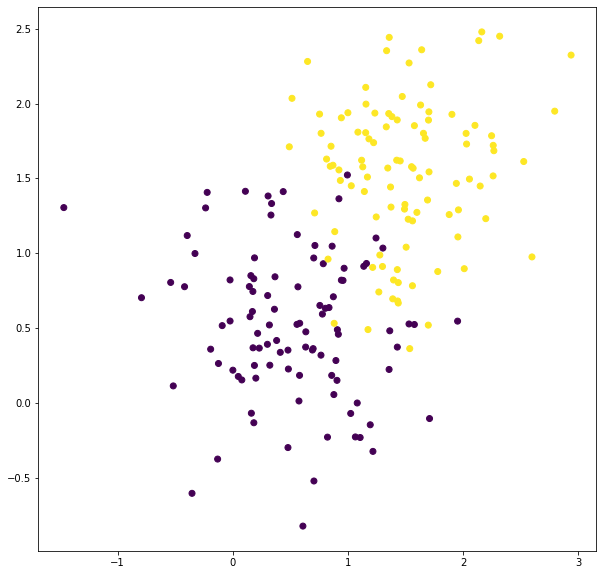

In [2]:
c1 = numpy.random.normal(0.5, 0.5, (100, 2))
c2 = numpy.random.normal(0.5, 0.5, (100, 2))
c2[:,0] = c2[:,0]+1
c2[:,1] = c2[:,1]+1

X = numpy.concatenate([c1, c2])
Y = numpy.zeros((200))
Y[100:] = 1

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=Y);

## GMMs
GMMs are, in some respects, KMeans on steriods. Again, we'll use 2 clusters and our [preferred](https://xkcd.com/221/) random number initialiser

In [3]:
gmm = GaussianMixture(2, random_state=4)
gmm.fit(X)

GaussianMixture(n_components=2, random_state=4)

While the GMM is in some respects like KMeans, it gives us a lot more out that we can use. For example, we can get:
* the means of the components. This is very much like the centres we get from KMeans
* the weights of the components, i.e. the relative size of each cluster
* the covariances of each cluster, this gives us the shape of the clusters

This last one is perhaps the most interesting. While KMeans has all clusters being circular, with a GMM the shape of each cluster can vary in response to the data. Not only that, but the density of the cluster can vary too. This makes GMMs much more flexible

In [4]:
print(gmm.means_)
print(gmm.weights_)
print(gmm.covariances_)

[[1.42516379 1.50473317]
 [0.51592363 0.47587212]]
[0.5366953 0.4633047]
[[[ 0.29255797  0.05396273]
  [ 0.05396273  0.24346788]]

 [[ 0.34636512 -0.04718927]
  [-0.04718927  0.22399182]]]


Let's look at some clustering results now.

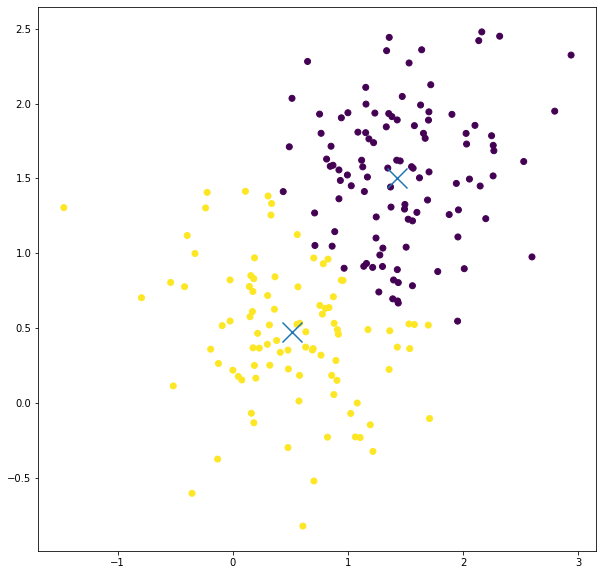

In [5]:
labels = gmm.predict(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)

And this looks a lot like KMeans, which is slightly anticlimactic. But there's more to it than that. 

When we assign points to clusters, we don't make a hard decision. Rather we get the likelihood of the point arising from each component. We can see this here:

In [6]:
probs = gmm.predict_proba(X)
print(probs[1:10,:])
print(probs[-10:,:])

[[0.65097378 0.34902622]
 [0.47080846 0.52919154]
 [0.00737393 0.99262607]
 [0.07713241 0.92286759]
 [0.1859096  0.8140904 ]
 [0.40869049 0.59130951]
 [0.03284005 0.96715995]
 [0.07631238 0.92368762]
 [0.42867073 0.57132927]]
[[9.99998675e-01 1.32452957e-06]
 [9.40119288e-01 5.98807124e-02]
 [9.46582293e-01 5.34177065e-02]
 [9.43775311e-01 5.62246891e-02]
 [9.99624019e-01 3.75981106e-04]
 [9.99785372e-01 2.14628185e-04]
 [9.99477290e-01 5.22710467e-04]
 [9.63690607e-01 3.63093928e-02]
 [9.98827000e-01 1.17299971e-03]
 [9.98311256e-01 1.68874364e-03]]


Here we look at 10 points that were created from the first distribution, and 10 there were created from the second. We can see that the first point is very likely belonging to the second cluster. All the points in this first set are more likely to belong ot the second cluster than the first, but the likelihood varies. Consider the last point for example, which we could reasonably expect lies close to the desicion boundary, and thus has partial membership of both classes.

We see the same in the second set of points, though in this case points belong mostly to the first cluster.

We can visualise the distributions to see what is happening (this code adatped from [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)).

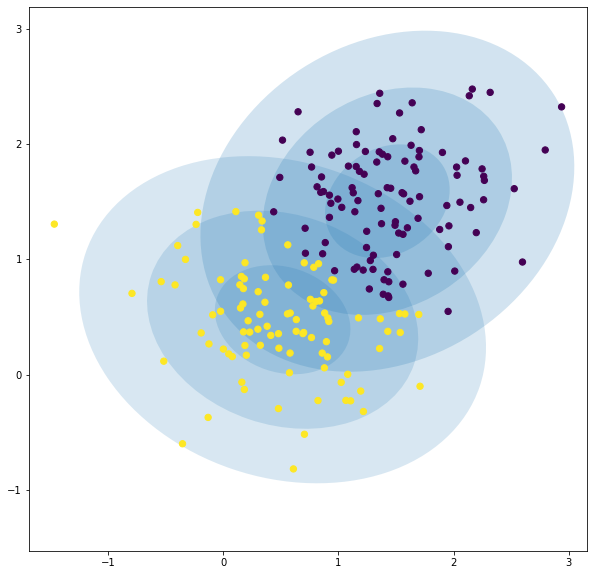

In [7]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = numpy.linalg.svd(covariance)
        angle = numpy.degrees(numpy.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * numpy.sqrt(s)
    else:
        angle = 0
        width, height = 2 * numpy.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):    
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
plot_gmm(gmm, X, ax=ax)

What we see here is that the two components overlap, so we have this region where points can belong to both clusters.

Like KMeans, GMMs also have a random component (they are initialised with KMeans after all). However as we see below, the variation (at least when using KMeans to initialise) is typically greatly reduced.

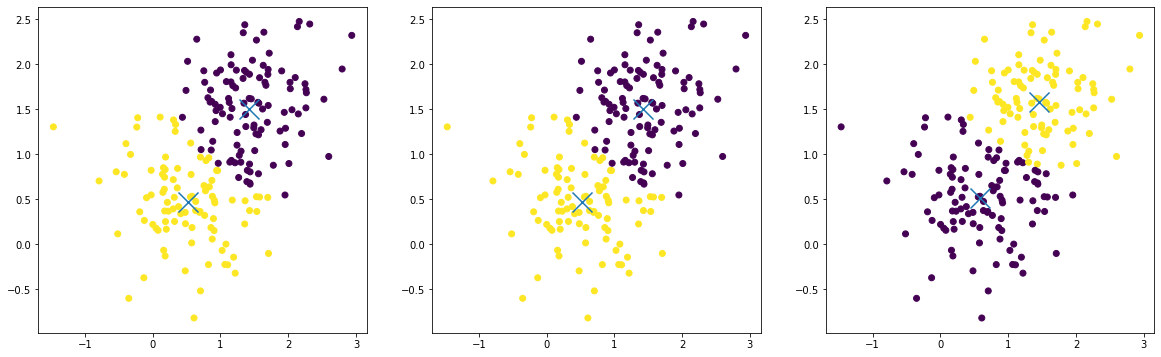

In [8]:
fig = plt.figure(figsize=[20, 6])

gmm = GaussianMixture(2, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(1, 3, 1)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)

gmm = GaussianMixture(2, random_state=44444)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)

gmm = GaussianMixture(2, random_state=44444444)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(1, 3, 3)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)

Let's use our circular data now.

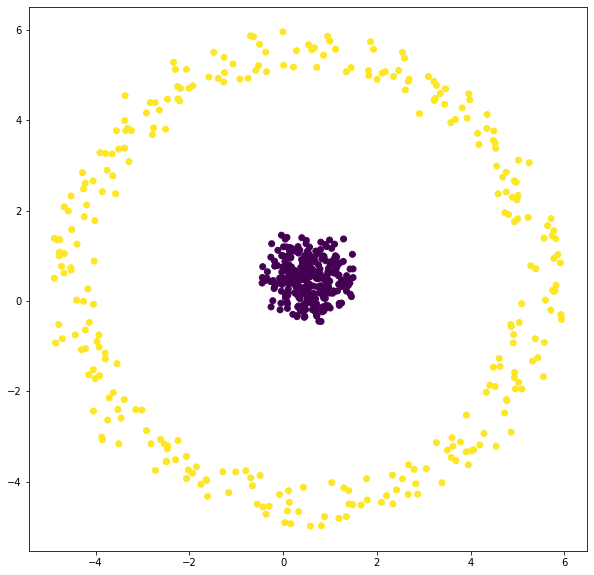

In [9]:
theta = numpy.arange(0, math.pi*2, math.pi*2/300)
theta = numpy.array([numpy.cos(theta), numpy.sin(theta)]).transpose()

c1 = 0.5*theta + numpy.random.random((300,2))
c2 = 5*theta + numpy.random.random((300,2))

X = numpy.concatenate([c1, c2])
Y = numpy.zeros((600))
Y[300:] = 1

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=Y);

We see in this case our fit is very similar to what we had with KMeans - in part becuase we are using KMeans to get an intial estimate.

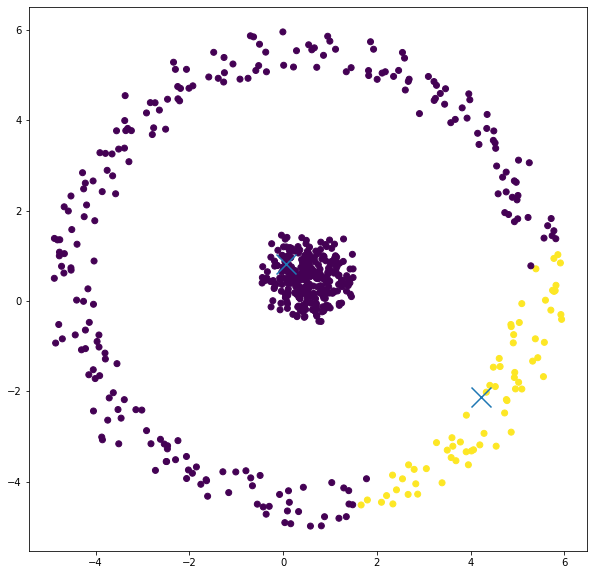

In [10]:
gmm = GaussianMixture(2, random_state=4)
gmm.fit(X)

labels = gmm.predict(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)

Plotting several versions of this with different random states,

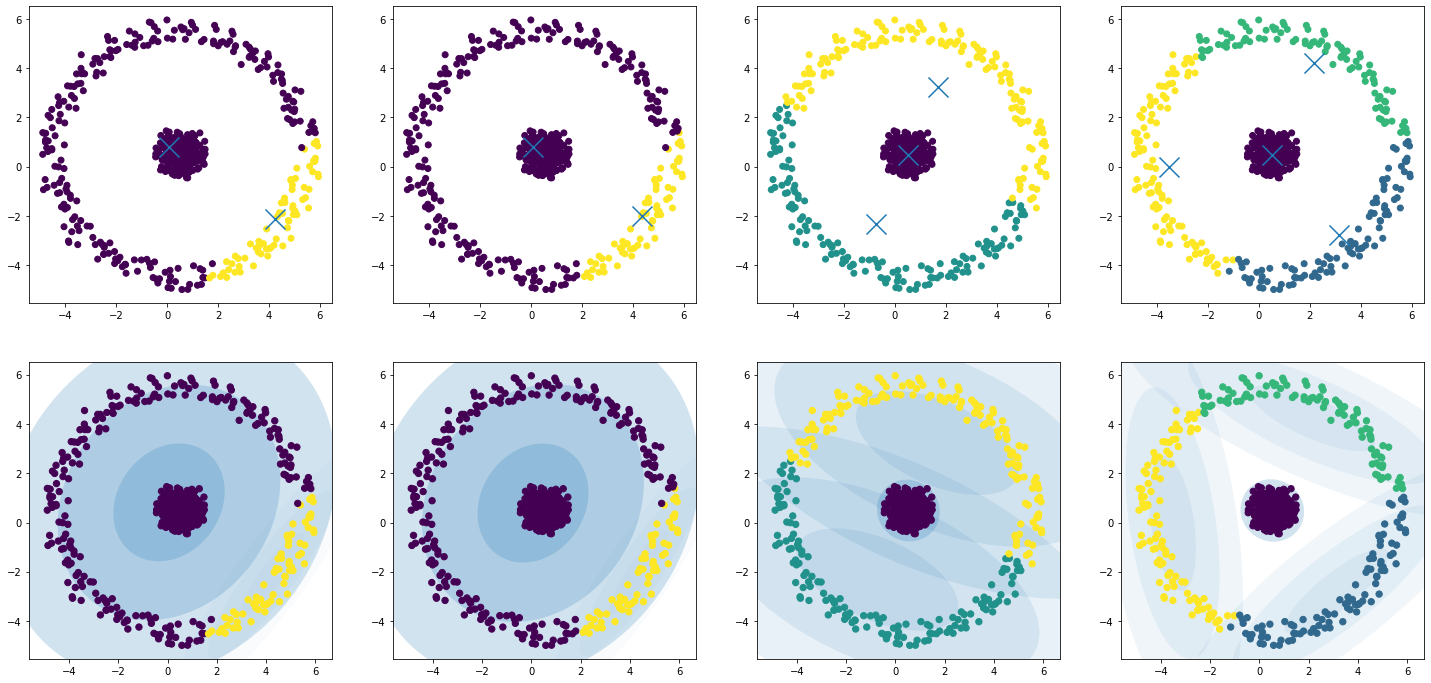

In [11]:
fig = plt.figure(figsize=[25, 12])

gmm = GaussianMixture(2, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 1)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 5)
plot_gmm(gmm, X, ax=ax)

gmm = GaussianMixture(2, random_state=44444)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 2)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 6)
plot_gmm(gmm, X, ax=ax)

gmm = GaussianMixture(3, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 3)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 7)
plot_gmm(gmm, X, ax=ax)

gmm = GaussianMixture(4, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 4)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 8)
plot_gmm(gmm, X, ax=ax)

We see that for the two class case we tend to get disapointing results, but as we move to three classes we can do a bit of a better job. What we can also see for the three and four cluster cases is that our clusters are all different shapes.

While a GMM usually uses KMeans to get an initial set of distributions to optimise, it doesn't have to. We can get it to initialise itself in a totally random way.

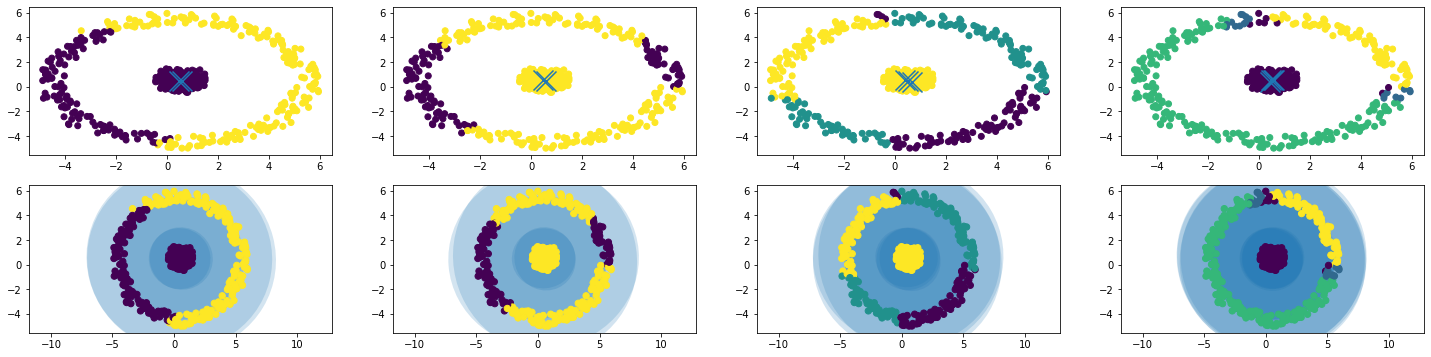

In [12]:
fig = plt.figure(figsize=[25, 6])

gmm = GaussianMixture(2, random_state=4, init_params='random')
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 1)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 5)
plot_gmm(gmm, X, ax=ax)

gmm = GaussianMixture(2, random_state=44444, init_params='random')
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 2)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 6)
plot_gmm(gmm, X, ax=ax)

gmm = GaussianMixture(3, random_state=4, init_params='random')
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 3)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 7)
plot_gmm(gmm, X, ax=ax)

gmm = GaussianMixture(4, random_state=4, init_params='random')
gmm.fit(X)
labels = gmm.predict(X)
ax = fig.add_subplot(2, 4, 4)
ax.scatter(X[:,0], X[:,1], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax = fig.add_subplot(2, 4, 8)
plot_gmm(gmm, X, ax=ax)


This leads to some different results. What we tend to see is that we learn multiple clusters with the same centre, but these clusters then have different shapes, and densities, and they overlap by a large margin. While these results aren't particularly useful (and are not what we know to the true result), they do illustrate one of the key ways that a GMM differs from KMeans: our clusters can overlap.

There will also exist a random initialisation that will lead to the correct segmentation, or we could manually initialise the process; however in the majority of real-world use cases you won't have prior knowledge of what the clustering results should look like. More often, we use clustering as a means to explore data about which we know very little.

The big advantage of a GMM over k-means is that we get the soft decisions. K-means will assign a point to a cluster, and won't give any indicatation if there were multiple centres that could have fit that cluster. A GMM will give us the likelihood of a point for each Guassian, so we get a better idea of where the point lies, and how close it is to multiple cluster centres.

Often when anaysing data and doing various machine learning tasks, we want to avoid hard decisions for as long as possible. K-means and it's assignment of points to a cluster can be seen as a hard decision. After we assign a point to a cluster, we lose any other information about where that point lies. A GMM helps overcome this. Now we can do a soft assignment, and help carry forward the uncertainty about which cluster a point belongs to until we get further into our analysis.